In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

import pandas as pd

In [3]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

In [4]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_train_imgs')
y_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_imgs')
y_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_masks')

x_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_imgs')
y_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_masks')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [7]:
# Inference
DEVICE = 'cpu'
best_model = torch.load('./models/best_model.pth', map_location=torch.device('cpu'))
best_model = best_model.to(DEVICE)

In [10]:
masks_path = os.path.join(DATA_DIR, 'map_input_data/seg_preds_all_valid_preproc.csv')

masks = pd.read_csv(masks_path)
masks.head()

,ImageID,ImageHeight,ImageWidth,LabelName,Score,Mask
0,41146970649b,512,512,blood_vessel,0.99,eNrLzU82NM60N/E29TGJ8ndOcUwyiLFzjnZMNEi1s/U3NA...
1,41146970649b,512,512,blood_vessel,0.98,eNrLywsyNU+3N/I3BEIjfwN/QwMENgASIKa/ka+pj6l3SG...
2,41146970649b,512,512,blood_vessel,0.97,eNrLiUs2MsyyN/Mz8jM0MPAHYiABhEZ+Jt5RiWGmAI3ECHM=
3,41146970649b,512,512,blood_vessel,0.98,eNpLiYs2Mc2wN/U39Df0MwKRQGjsa+pl5m3sa2Dgb2gAJP...
4,41146970649b,512,512,blood_vessel,0.97,eNoLyE03Ncu0N/I3hEIDAyAGMgwM/UBcIz8j34ygACMA2S...


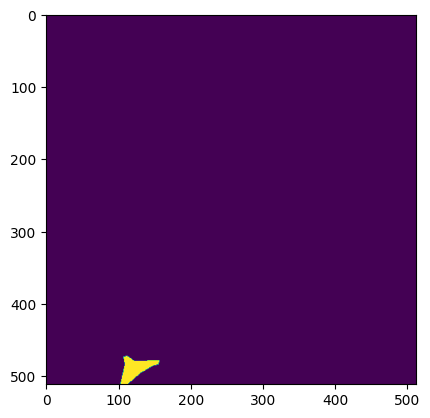

In [29]:
import zlib
import base64
from pycocotools import _mask as coco_mask
import matplotlib.pyplot as plt

def decodeMask(mask_string, image_size=[512,512]):
    decoded_base64 = base64.b64decode(mask_string.encode('utf-8'))
    decompressed_str = zlib.decompress(decoded_base64)
    decoded_mask = coco_mask.decode([{"size": image_size,"counts": decompressed_str}])
    return decoded_mask

sampleMask = decodeMask(masks.iloc[0]['Mask'])

plt.imshow(sampleMask)